In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime

import tensorflow as tf
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

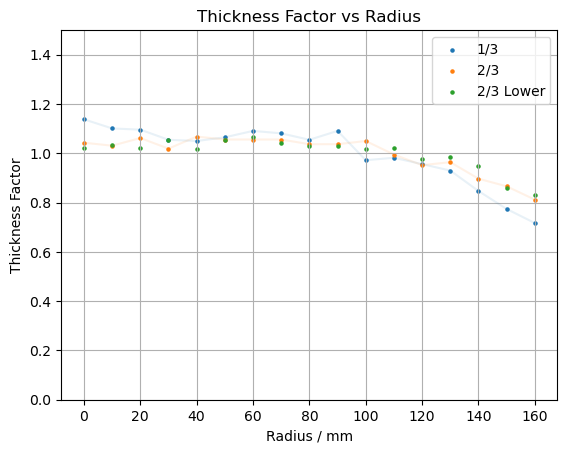

In [7]:
# Import data
df = pd.read_csv('data/ebeam/EB1321.csv') # 1/3
dfnp1 = df.to_numpy()
df = pd.read_csv('data/ebeam/EB1322.csv') # 2/3
dfnp2 = df.to_numpy()
df = pd.read_csv('data/ebeam/EB1323.csv') # 3/3
dfnp3 = df.to_numpy()

if not np.array_equal(dfnp1[:,0], dfnp2[:,0]):
    raise ValueError('Radii do not match')
radii = dfnp1[:,0]
MAX_RADIUS = np.max(radii)

# Normalise radii
radii_norm = radii / MAX_RADIUS
thickness_factors1 = dfnp1[:,1]
thickness_factors2 = dfnp2[:,1]
thickness_factors3 = dfnp3[:,1]

# Extract fullness
full1 = dfnp1[:,2][0]
full2 = dfnp2[:,2][0]
full3 = dfnp3[:,2][0]

# Extract height
height1 = dfnp1[:,3][0]
height2 = dfnp2[:,3][0]
height3 = dfnp3[:,3][0]

# Plot data
plt.scatter(radii, thickness_factors1, label='1/3', s=5)
plt.scatter(radii, thickness_factors2, label='2/3', s=5)
plt.scatter(radii, thickness_factors3, label='2/3 Lower', s=5)
plt.plot(radii, thickness_factors1, alpha=0.1)
plt.plot(radii, thickness_factors2, alpha=0.1)
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor vs Radius')
plt.ylim(0, 1.5)
plt.legend()
plt.grid()
plt.show()


#### Fit the Data

In [8]:
X_train = []
for i in range(len(radii_norm)):
    X_train += [[radii_norm[i], full1, height1]]
for i in range(len(radii_norm)):
    X_train += [[radii_norm[i], full2, height2]]
for i in range(len(radii_norm)):
    X_train += [[radii_norm[i], full3, height3]]
X_train = np.array(X_train)
print(f'X_train.shape = {X_train.shape}')

y_train = np.append(thickness_factors1, thickness_factors2)
y_train = np.append(y_train, thickness_factors3)
print(f'y_train.shape = {y_train.shape}')

X_train.shape = (51, 3)
y_train.shape = (51,)


In [9]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='gelu', input_shape=(3,)),
    tf.keras.layers.Dense(64, activation='gelu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=17500, verbose=0)

In [ ]:
# Load model instead
model = tf.keras.models.load_model('models/ebeam/ebeam-230630-1045.h5')

In [11]:
# Define curve function
def get_tf(r, full, height):
    r_norm = r/MAX_RADIUS
    full_ = full*np.ones_like(r_norm)
    height_ = height*np.ones_like(r_norm)
    X_test = np.column_stack((r_norm, full_, height_))
    y_test = model.predict(X_test)
    return np.squeeze(y_test)

In [22]:
# Save the model
optional_desc = 'ebeam'
dt = datetime.now().strftime('%y%m%d-%H%M')
if optional_desc == '':
    optional_desc = 'model'
model_path = f'models/plasma/{optional_desc}-{dt}.h5'
model.save(model_path)

#### Plot the results

16/16 [==============================] - 0s 2ms/step


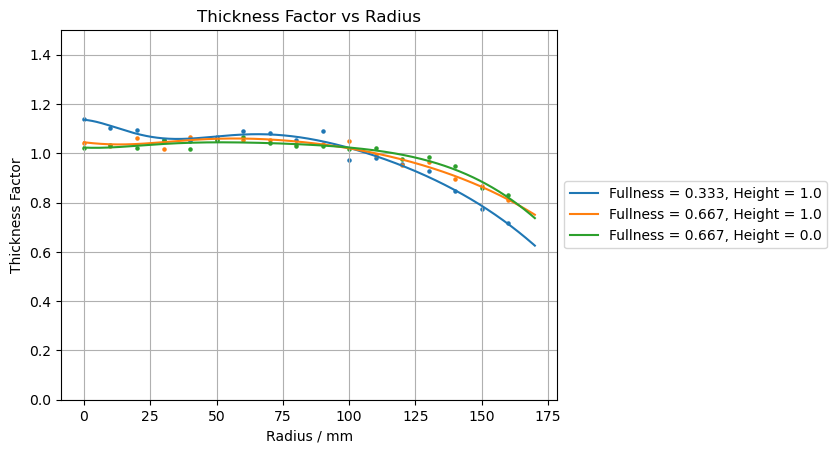

In [12]:
# Plot the results
radii_ = np.linspace(0, 170, 500)
tf1 = get_tf(radii_, full1, height1)
tf2 = get_tf(radii_, full2, height2)
tf3 = get_tf(radii_, full3, height3)

plt.plot(radii_, tf1, color='C0', label=f'Fullness = {full1}, Height = {height1}')
plt.plot(radii_, tf2, color='C1', label=f'Fullness = {full2}, Height = {height2}')
plt.plot(radii_, tf3, color='C2', label=f'Fullness = {full3}, Height = {height3}')
plt.scatter(radii, thickness_factors1, s=5, color='C0')
plt.scatter(radii, thickness_factors2, s=5, color='C1')
plt.scatter(radii, thickness_factors3, s=5, color='C2')
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor vs Radius')
plt.ylim(0, 1.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

#### Thickness map visualisation

In [14]:
# Load plate geometry
with open('tapejig/plate_dims.txt', 'r') as f:
    plate_dims = f.readlines()
plate_dims = [float(x) for x in plate_dims]

PLATE_X = plate_dims[0]
PLATE_Y = plate_dims[1]
CENTER_X = PLATE_X / 2
CENTER_Y = PLATE_Y / 2

313/313 [==============================] - 1s 2ms/step


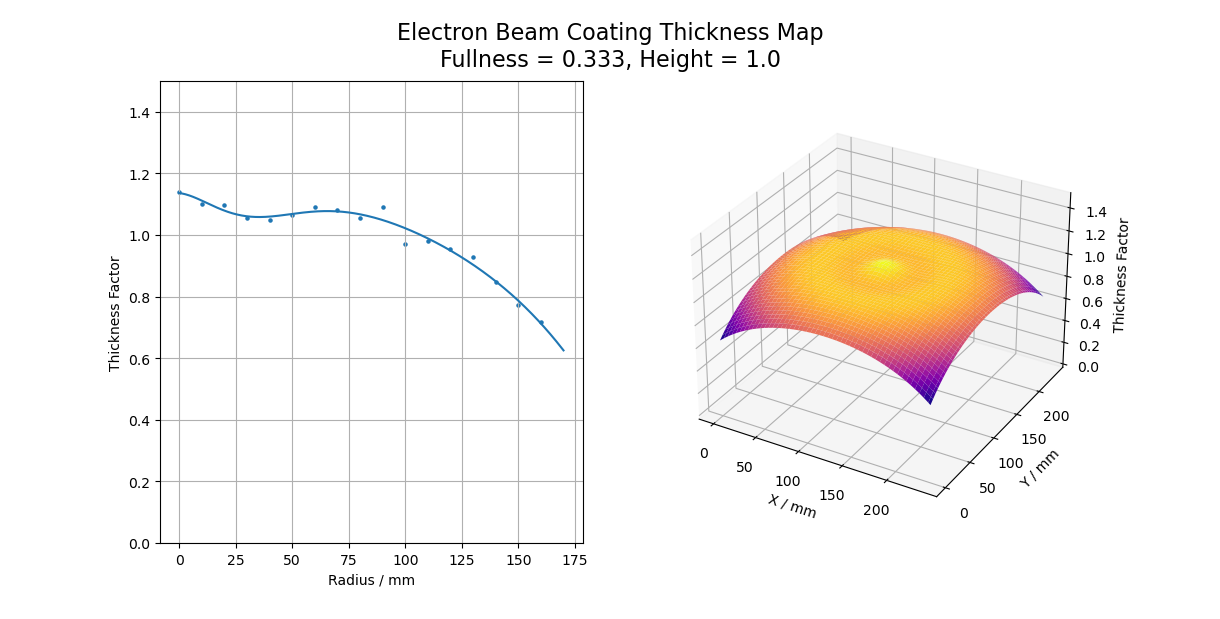

313/313 [==============================] - 1s 2ms/step


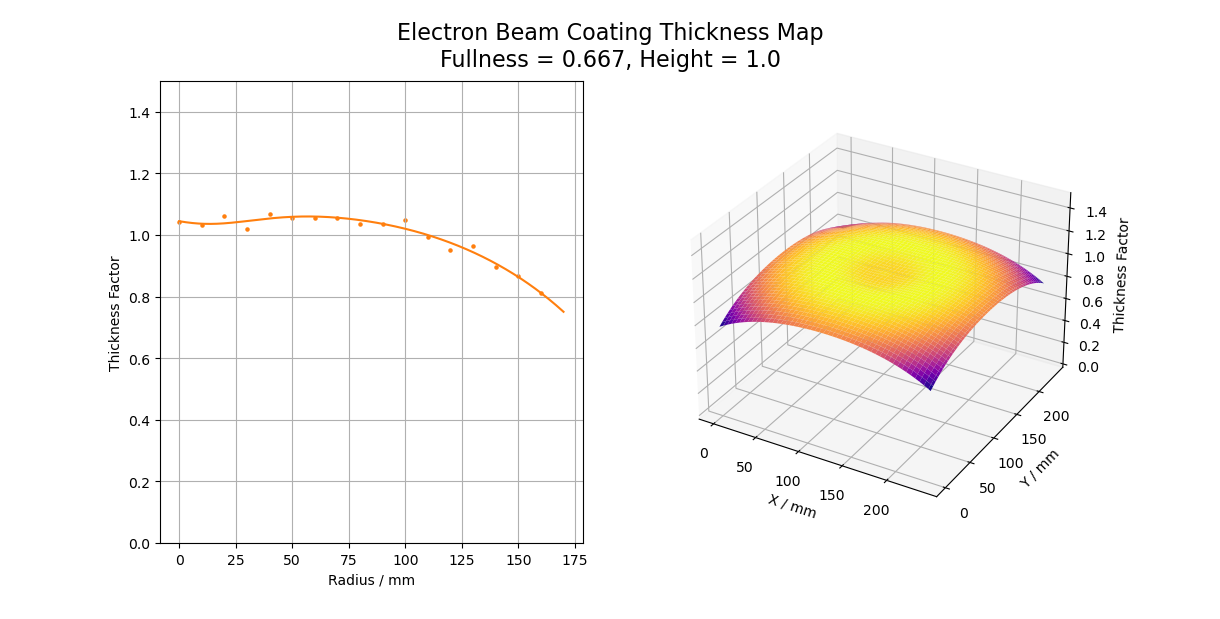

313/313 [==============================] - 1s 2ms/step


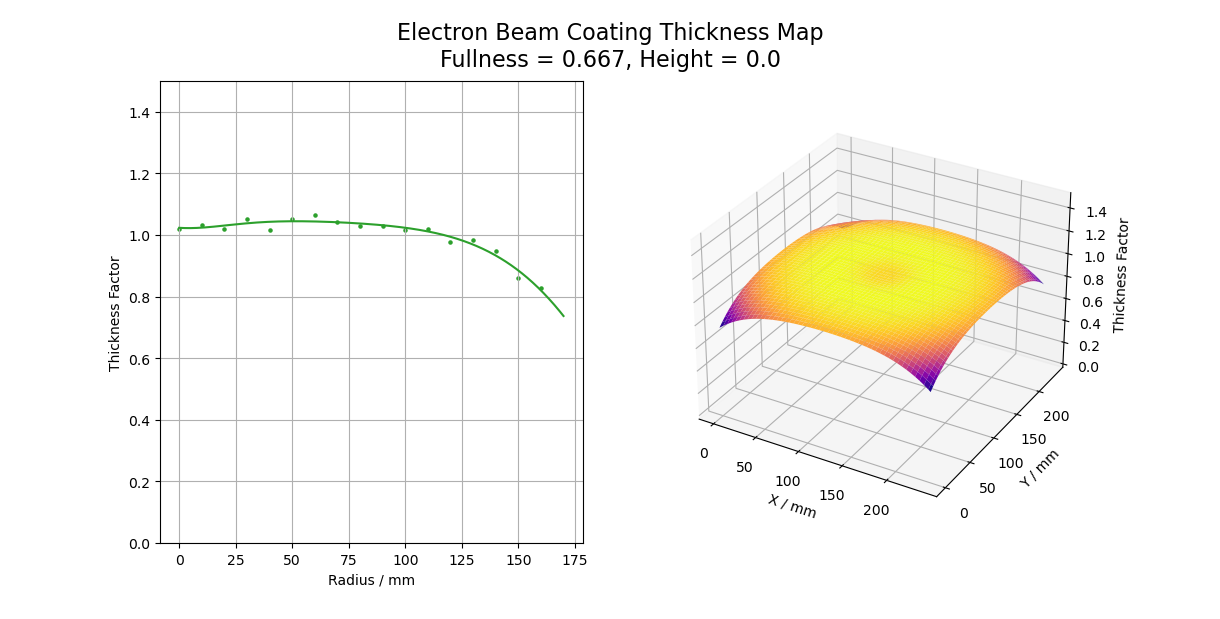

In [23]:
# Plot 1st profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)

rr_ = np.ravel(np.sqrt((xx_ - CENTER_X)**2 + (yy_ - CENTER_Y)**2)) # radius map
rr_ = np.ravel(rr_)
zz_ = get_tf(rr_, full1, height1)
zz_ = np.reshape(zz_, xx_.shape)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], projection='3d')

ax1.plot(radii_, tf1, color='C0')
ax1.scatter(radii, thickness_factors1, s=5, color='C0')
ax1.set_xlabel('Radius / mm')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0, 1.5)
ax1.grid()

ax2.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')
ax2.set_xlabel('X / mm')
ax2.set_ylabel('Y / mm')
ax2.set_zlabel('Thickness Factor')
ax2.set_zlim(0, 1.5)

fig.suptitle(f'Electron Beam Coating Thickness Map\nFullness = {full1}, Height = {height1}', fontsize=16)
fig.add_axes([0,0,1,1]).axis("off")
plt.show()

# Plot 2nd profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)

rr_ = np.ravel(np.sqrt((xx_ - CENTER_X)**2 + (yy_ - CENTER_Y)**2)) # radius map
rr_ = np.ravel(rr_)
zz_ = get_tf(rr_, full2, height2)
zz_ = np.reshape(zz_, xx_.shape)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], projection='3d')

ax1.plot(radii_, tf2, color='C1')
ax1.scatter(radii, thickness_factors2, s=5, color='C1')
ax1.set_xlabel('Radius / mm')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0, 1.5)
ax1.grid()

ax2.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')
ax2.set_xlabel('X / mm')
ax2.set_ylabel('Y / mm')
ax2.set_zlabel('Thickness Factor')
ax2.set_zlim(0, 1.5)

fig.suptitle(f'Electron Beam Coating Thickness Map\nFullness = {full2}, Height = {height2}', fontsize=16)
fig.add_axes([0,0,1,1]).axis("off")
plt.show()

# Plot 3rd profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)

rr_ = np.ravel(np.sqrt((xx_ - CENTER_X)**2 + (yy_ - CENTER_Y)**2)) # radius map
rr_ = np.ravel(rr_)
zz_ = get_tf(rr_, full3, height3)
zz_ = np.reshape(zz_, xx_.shape)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], projection='3d')

ax1.plot(radii_, tf3, color='C2')
ax1.scatter(radii, thickness_factors3, s=5, color='C2')
ax1.set_xlabel('Radius / mm')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0, 1.5)
ax1.grid()

ax2.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')
ax2.set_xlabel('X / mm')
ax2.set_ylabel('Y / mm')
ax2.set_zlabel('Thickness Factor')
ax2.set_zlim(0, 1.5)

fig.suptitle(f'Electron Beam Coating Thickness Map\nFullness = {full3}, Height = {height3}', fontsize=16)
fig.add_axes([0,0,1,1]).axis("off")
plt.show()

#### Applying the model to the tape targets

In [17]:
# Load target radii from csv
df = pd.read_csv('tapejig/target_radii.csv')
n = np.array(df['Target Number'].values)
target_radii = np.array(df['Radius'].values)

6/6 [==============================] - 0s 3ms/step
Number of targets within 0.85 and 1.15:   174/180
Mean: 1.031   Std: 0.053


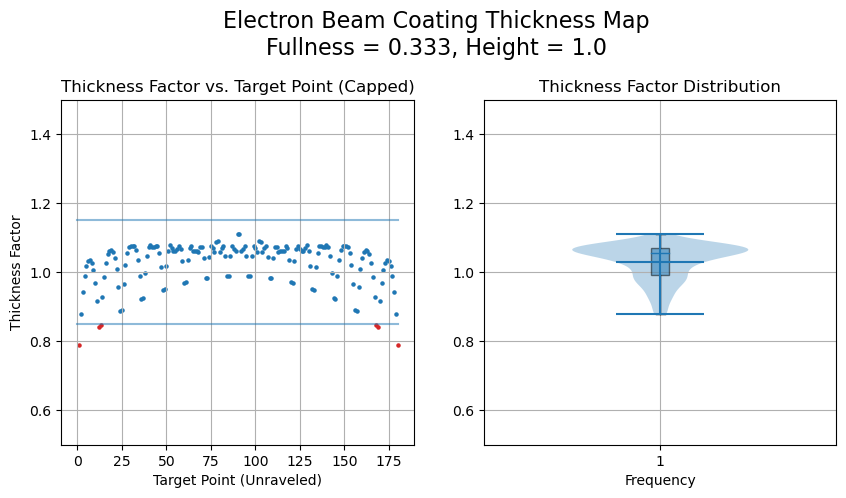

Number of targets within 0.85 and 1.15:   180/180
Mean: 1.022   Std: 0.041


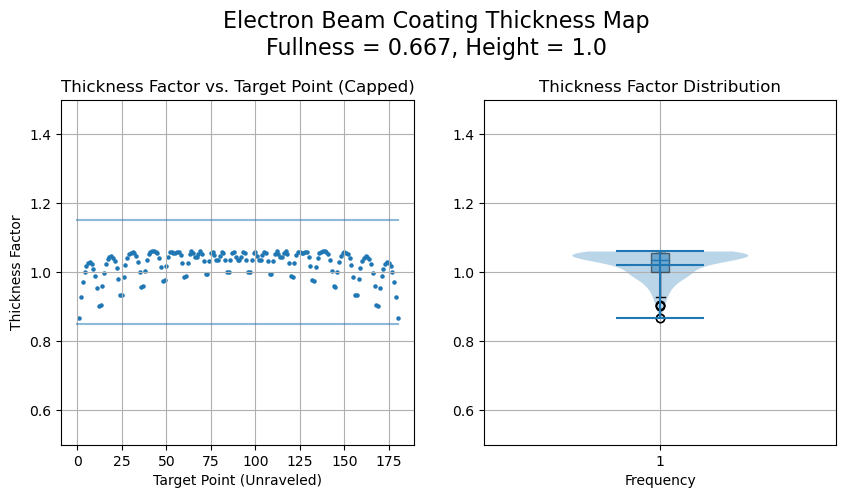

Number of targets within 0.85 and 1.15:   180/180
Mean: 1.021   Std: 0.029


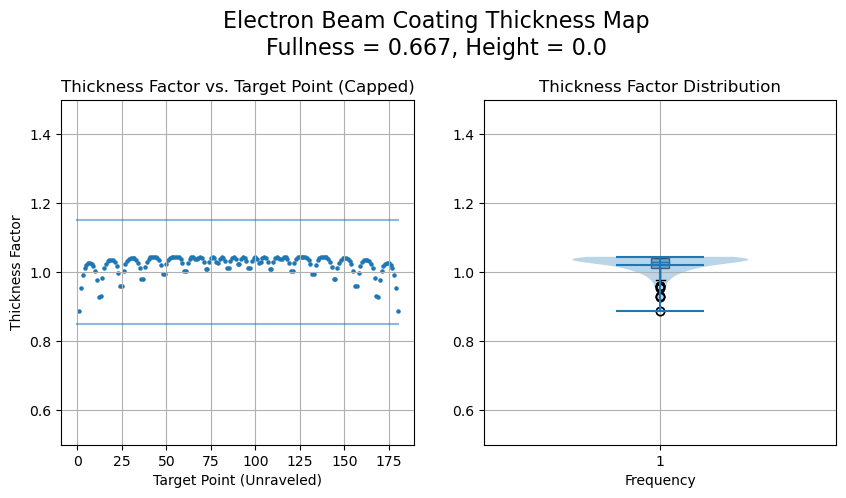

In [24]:
TF_FLOOR = 0.85
TF_CEILING = 1.15

# Get thickness factors
target_tf1 = get_tf(target_radii, full1, height1)
target_tf2 = get_tf(target_radii, full2, height2)
target_tf3 = get_tf(target_radii, full3, height3)

## 1st profile ##
arg_ok = np.where((target_tf1 >= TF_FLOOR) & (target_tf1 <= TF_CEILING))[0]
arg_notok = np.where((target_tf1 < TF_FLOOR) | (target_tf1 > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfok1 = target_tf1[arg_ok]

n_notok = n[arg_notok]
target_tfnotok1 = target_tf1[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfok1):.3f}   Std: {np.std(target_tfok1):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfok1, s=5)
ax1.scatter(n_notok, target_tfnotok1, s=5, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0.5, 1.5)
ax1.set_title('Thickness Factor vs. Target Point (Capped)')
ax1.grid()

box = ax2.boxplot(target_tfok1, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfok1, showmeans=True)
ax2.set_xlim(0.5, 1.5)
ax2.set_ylim(0.5, 1.5)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()

fig.suptitle(f'Electron Beam Coating Thickness Map\nFullness = {full1}, Height = {height1}', fontsize=16)
fig.subplots_adjust(top=0.80)
plt.show()


## 2nd profile ##
arg_ok = np.where((target_tf2 >= TF_FLOOR) & (target_tf2 <= TF_CEILING))[0]
arg_notok = np.where((target_tf2 < TF_FLOOR) | (target_tf2 > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfok2 = target_tf2[arg_ok]

n_notok = n[arg_notok]
target_tfnotok2 = target_tf2[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfok2):.3f}   Std: {np.std(target_tfok2):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfok2, s=5)
ax1.scatter(n_notok, target_tfnotok2, s=5, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0.5, 1.5)
ax1.set_title('Thickness Factor vs. Target Point (Capped)')
ax1.grid()

box = ax2.boxplot(target_tfok2, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfok2, showmeans=True)
ax2.set_xlim(0.5, 1.5)
ax2.set_ylim(0.5, 1.5)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()

fig.suptitle(f'Electron Beam Coating Thickness Map\nFullness = {full2}, Height = {height2}', fontsize=16)
fig.subplots_adjust(top=0.80)
plt.show()


## 3rd profile ##
arg_ok = np.where((target_tf3 >= TF_FLOOR) & (target_tf3 <= TF_CEILING))[0]
arg_notok = np.where((target_tf3 < TF_FLOOR) | (target_tf3 > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfok3 = target_tf3[arg_ok]

n_notok = n[arg_notok]
target_tfnotok3 = target_tf3[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfok3):.3f}   Std: {np.std(target_tfok3):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfok3, s=5)
ax1.scatter(n_notok, target_tfnotok3, s=5, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0.5, 1.5)
ax1.set_title('Thickness Factor vs. Target Point (Capped)')
ax1.grid()

box = ax2.boxplot(target_tfok3, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfok3, showmeans=True)
ax2.set_xlim(0.5, 1.5)
ax2.set_ylim(0.5, 1.5)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()

fig.suptitle(f'Electron Beam Coating Thickness Map\nFullness = {full3}, Height = {height3}', fontsize=16)
fig.subplots_adjust(top=0.80)
plt.show()

In [21]:
# Export data as df in csv
df = pd.DataFrame({'Target Number': n, 'Thickness Factor': target_tf1})
df.to_csv('exports/ebeam-0.33.csv', index=False)

# Export data as df in csv
df = pd.DataFrame({'Target Number': n, 'Thickness Factor': target_tf2})
df.to_csv('exports/ebeam-0.66.csv', index=False)

# Export data as df in csv
df = pd.DataFrame({'Target Number': n, 'Thickness Factor': target_tf3})
df.to_csv('exports/ebeam-0.66-lower.csv', index=False)